In [289]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as lm

For cleaness of coding, all the functions involved in the homework are gathered here.

In [290]:
# Functions
def solveRidgeRegression(X_train, y_train, lam):
  # Generate A
  A = np.identity(X_train.shape[1])
  A[0, 0] = 0
  theta = np.linalg.inv(X_train.T @ X_train + lam * A) @ X_train.T @ y_train  

  return theta

def solveLeastSquareRegression(X, y):
  LinRe = lm.LinearRegression()
  LinRe.fit(X, y)

  return LinRe.coef_

def foldsGeneneration(X, y, K):
  # Calculate the number of samples in a single fold
  fold_size = X.shape[0] // K

  # Initialize folds
  folds_X = np.zeros([K, fold_size, X.shape[1]])
  folds_y = np.zeros([K, fold_size])

  # Generate 5 folds
  for i in range(0, K):
    random_indices = np.random.choice(X.shape[0], fold_size, replace = False)
    
    folds_X[i, :, :] = X[random_indices]
    folds_y[i,:] = y[random_indices]
  
  return folds_X, folds_y

# Calculate the error of a single theta with given test sets 
def thetaError(theta, X_test, y_test):
  error = 0
  for i in range(X_test.shape[0]):
    error_layer = ((y_test[i, :] - X_test[i, :, :] @ theta) ** 2).mean()
    error += error_layer / X_test.shape[0]

  return error

# Homework 3

## Problem 1

It could be the case that just by chance, the generated validation set correspondes perfectly to the trained model, meaning that the validation didn't represent the true performance of the model.

## Problem 2

According to the lecture note we have

$$
\text{P} \left[ \underset{k=1,\cdots,K}{\text{max}} \left| \hat{R} \left(h_k, \mathcal{D}_{val} \right) - R\left( h_K \right) \right| \le O\left( \sqrt{\frac{\text{log} \left( K / \delta \right)}{\left| \mathcal{D}_{val} \right|}} \right) \right] \ge 1- \delta ,
$$

to correctly chose a $k$ without runging into problem, we can look at the term

$$
\sqrt{\frac{\text{log} \left( K / \delta \right)}{\left| \mathcal{D}_{val} \right|}},
$$

to obtain a validation error that gives a good estimate of the risk for all hyperparameter configurations, $\text{log}(K)$ should be small relative to $\left| \mathcal{D}_{val} \right|$, i.e.,

$$
\text{log}(K) \le \left| \mathcal{D}_{val} \right| ~~~~~~ \Rightarrow ~~~~~~ K \le e^{\left| \mathcal{D}_{val} \right|} .
$$

Let the $\left| \mathcal{D}_{val,small} \right|$ for the small validation set be $a$ and therefore for the large validation set $\left| \mathcal{D}_{val,large} \right| = 10 \cdot a$. On the small validation set we can evaluate $e^a$ models and on the large validation set, $e^{10 \cdot a}$ models can be tested.

## Problem 3

### 1.

Some features have larger deviation because of their nature, and during the ridge regression, these variables will receive larger penalty, which makes them more "important" than they should be.

By scaling the variables, the effect of different variables on the final model is normalized.

### 2.

We can define the feature vector as $\mathbf{\theta}_{\text{ridge}} = \left[\theta_0, \theta_1, \cdots, \theta_d \right] = \left[ \theta_0, \mathbf{\theta} \right] \in \mathbb{R}^{d+1}$. Together with the given definition of $\tilde{\mathbf{X}}$, we have traditional ridge regeression as follows:

$$
\begin{alignat*}{2}
  \hat{\mathbf{\theta}}_{\text{ridge}} &= \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \left\| \mathbf{\theta}_{\text{ridge}} \right\|_2^2 \\
  &= \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \mathbf{\theta}_{\text{ridge}}^\top \mathbf{\theta}_{\text{ridge}}.
\end{alignat*}
$$

According to the task, $\theta_0$ should not be considered for the penalty, to achieve this, we can multiply the penalty term with an identity, but starting with 0, denoted as $\mathbf{A}$ i.e.,

$$
\mathbf{A} = \begin{bmatrix}
0 &                         \\
  & \mathbf{I}_{N \times N}
\end{bmatrix} \in \mathbb{R}^{N+1 \times N+1},
$$

by doing this, the ridge regression problem can be rewritten as

$$
\hat{\mathbf{\theta}}_{\text{ridge}} = \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \mathbf{\theta}_{\text{ridge}}^\top \mathbf{A} \mathbf{\theta}_{\text{ridge}}.
$$

We can replace the identity term $\mathbf{I}$ in closed-form solution of ridge regression with the newly defined $\mathbf{A}$, leading to

$$
\hat{\mathbf{\theta}}_{ridge} = \left( \mathbf{X}^{\top} \mathbf{X} + \lambda \mathbf{A} \right)^{-1} \mathbf{X}^{\top} \mathbf{y}
$$

### 3.

Text(0, 0.5, '2-norm')

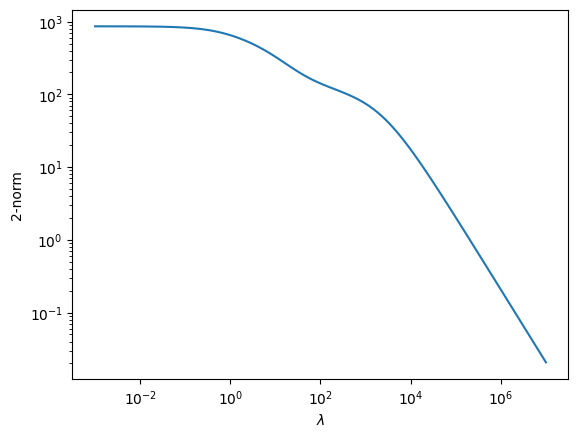

In [291]:
# Load data
X = np.loadtxt("hitters/hitters.x.csv", delimiter = ",", skiprows = 1)

with open("hitters/hitters.x.csv", "r") as f:
  features = next(csv.reader(f))

y = np.loadtxt("hitters/hitters.y.csv", delimiter = ",", skiprows = 1)

# Normalize data
SS = StandardScaler()
X = SS.fit_transform(X)

# Add ones to the data
X = np.hstack((np.ones([np.shape(X)[0],1]), X))

# Generate lambda array
lam_array = np.logspace(-3, 7, 100)

# Create a empty theta matrix with arrays for thetas
thetas_r = np.zeros([lam_array.shape[0], X.shape[1]])

# Perform ridge regression for every lambda
for i in range(lam_array.shape[0]):
  lambda_curr = lam_array[i]
  thetas_r[i, :] = solveRidgeRegression(X, y, lambda_curr)

# Calculate the norm of the thetas, note to exclude the first column
norms = np.linalg.norm(thetas_r[:, 1:], axis = 1)

# Plot the result
plt.loglog(lam_array, norms)
plt.xlabel('$\lambda$')
plt.ylabel('2-norm')

### 4.

To compare the components between Least Square Regression and Ridge Regression, lets compute the Least Square Regression first.

In [292]:
thetas_ls = solveLeastSquareRegression(X, y)

And then, calculate $\hat{\mathbf{\theta}}_{\text{least\_square}} - \hat{\mathbf{\theta}}_{\text{ridge}}'$, with $\hat{\mathbf{\theta}}_{\text{ridge}}'$ is calculated based on the smallest $\lambda$, this should give us a vector with all entries close to 0 except the first one.

In [293]:
thetas_ls - thetas_r[0, :]

array([-5.35925844e+02, -1.77269975e-02,  6.07359232e-02,  3.62065513e-02,
       -5.60956785e-02, -3.32910000e-02,  1.47171011e-02,  3.59772123e-02,
       -2.25292967e-01, -1.95002344e-01, -1.30221672e-01,  3.18522812e-01,
        2.33478259e-01, -5.20369133e-02, -6.21975491e-04,  2.99697362e-03,
       -1.26048117e-05,  7.55775105e-03,  3.22899183e-03,  3.68485864e-03])

To further prove that, as $\lambda$ increasing, the coeffients derived by ridge regression is approaching 0, we can plot the changing of $\hat{\mathbf{\theta}}_{\text{ridge}}$ w.r.t. $\lambda$

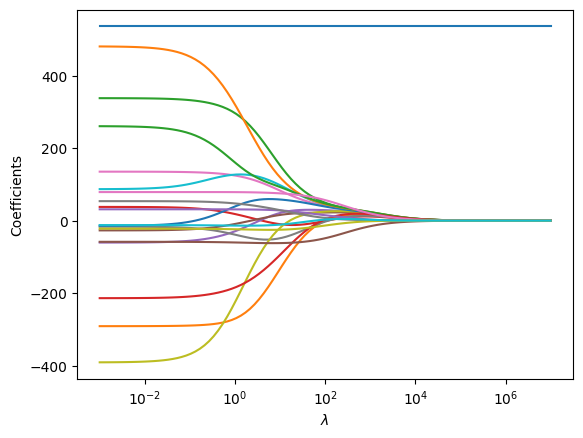

In [294]:
for i in range(thetas_r.shape[1]):
  plt.semilogx(lam_array, thetas_r[:, i])
  plt.xlabel("$\lambda$")
  plt.ylabel("Coefficients")

### 5.

Text(0, 0.5, 'Cross Validation Error')

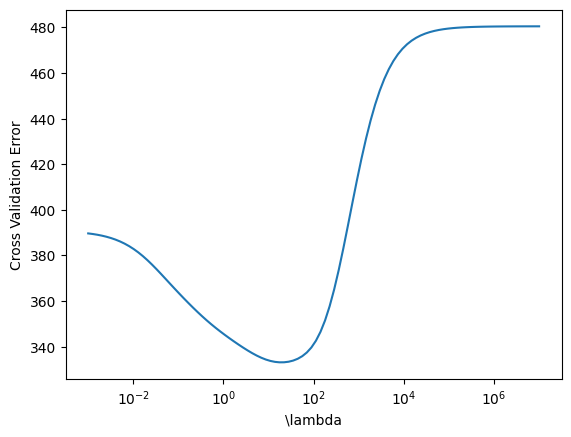

In [295]:
# Set number of folds
K = 5

folds_X, folds_y = foldsGeneneration(X, y, K)

# For every lambda, 5 thetas can be calculated
error = np.zeros([lam_array.shape[0], K])

# For the i-th lambda
for i in range(lam_array.shape[0]):
  lam = lam_array[i]
  # And the j-th fold as training set
  for j in range(K):
    # Generate training set and test sets
    X_train = folds_X[j, :, :]
    y_train = folds_y[j, :]
    
    X_test = np.delete(folds_X, j, axis = 0)
    y_test = np.delete(folds_y, j, axis = 0)

    theta = solveRidgeRegression(X_train, y_train, lam)
    error[i, j] = thetaError(theta, X_test, y_test)

error_cv = np.sqrt(np.mean(error, axis=1))

plt.semilogx(lam_array, error_cv)
plt.xlabel("\lambda")
plt.ylabel("Cross Validation Error")

### 6.

To determine the best coefficients, first find the best $\lambda$

In [298]:
star_index = np.argmin(error_cv)
lam_star = lam_array[star_index]
print("best lambda = ", lam_star)

best lambda =  17.47528400007683


train the model based on this $\lambda$, and plot the result according to their categories, 

<BarContainer object of 19 artists>

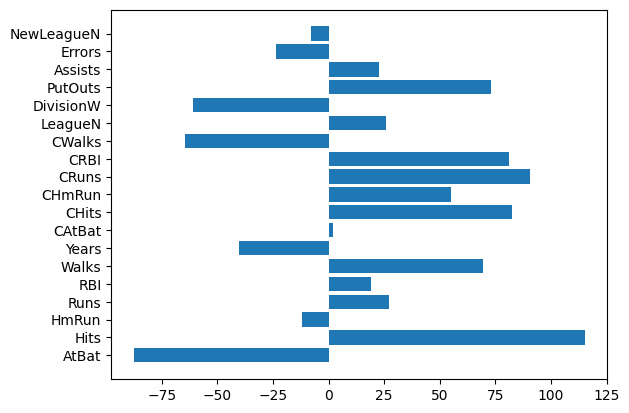

In [316]:
theta_rr_star = solveRidgeRegression(X, y, lam_star)
theta_rr_star = np.delete(theta_rr_star, 0, axis=0)

feature_array = np.array(features)

plt.barh(feature_array, theta_rr_star)

We should focus on the most positive terms to ensure a higer salary.